<a href="https://colab.research.google.com/github/COGS118A/Group005-Sp22/blob/main/FinalProject_group005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGS 118A - Final Project

# Predicting App Ratings

## Group members

- Hsi Chen
- Brandon Vazquez-Tellez
- Vicky Chou
- Adam Yoshinaga

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 
- what your goal/problem is
- what the data used represents 
- the solution/what you did
- major results you came up with (mention how results are measured) 

__NB:__ this final project form is much more report-like than the proposal and the checkpoint. Think in terms of writing a paper with bits of code in the middle to make the plots/tables

# Background

As our daily routines depend more on mobile apps, apps with high ratings can suggest different meanings like how entertaining apps are or how helpful they are in our lives. Certain apps may become more popular as users give higher ratings, and people are more willing to download and use apps with higher ratings. Different models have been used to predict app ratings, such as Random Forest Regressor or XGboost models used to predict Google Apps Rating in this dataset<sup>[1](#1)</sup>. Such predictions take into account of areas like app category, price, content rating, number of installs, or reviews to see what features influence the ratings more. An area of ongoing research in machine learning is natural language processing, which is a field that uses algorithms for detecting words in sentences and interpreting the semantics behind the way the words were phrased. Natural language processing could potentially be used to analyze app ratings when considering users' reviews, but not much has actually been done to determine how 'good' or how high of a rating the application deserves based on the pattern between the words used in reviews and the rating given<sup>[2](#2)</sup>. Linear regression is one of the most popular and most widely used algorithms. Being one of the oldest techniques, we can also say that it is one of those algorithms which have been studied immensely to understand and implement. Hence you will find a million different implementations and names for Linear Regression<sup>[3](#3)</sup>.

# Problem Statement

The problem we are solving is predicting an app's rating, which is quantifiable, measurable, and replicable, by analyzing which components of an app predict/impact its rating more accurately as well as to what degree. By finding which components have the most effect, we can come to understand the features that constitute to an app's success and hence eliminate aspects of an app that drag down its ratings. Predictions of app ratings are quantifiable and measurable as they are measured in a mathematical scale. It is replicable because we can calculate the ratings based on differences in an app's features. Some ML-relevant potential solutions are Ordinary Least Squares, one-hot encoding, data wrangling, linear regression, and other Python functions.


# Data

* Link: https://www.kaggle.com/code/jemseow/machine-learning-to-predict-app-ratings
* Size of the dataset: # of variables - 10; # of observations - 9660
* An observation consists of the app name and its category, rating, number of reviews, size, number of installs, trial type, price, content rating, and genres.
* Some critical variables are rating and reviews since they are directly related to people's opinions and ratings of the app. Ratings are represented through numbers on a scale of 1 to 19, and the number of reviews are represented through numbers ranging from 0 to 78.2m.
* One-hot encoding, data wrangling, and implementation of methods we have learned in this class will be needed. 
* **Cleaning methods**: Remove nulls, fill missing values with median, remove special characters from the string and convert it into usable format. 



In [233]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import auc, accuracy_score, mean_absolute_error, mean_squared_error
from scipy.special import boxcox, inv_boxcox
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE


pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/COGS118A/Group005-Sp22/main/googleplaystore.csv')


In [ ]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Data Conversion
Before taking a look at the data, we want to clean up the dataset as well as the columns to make the data more readable by our algorithms later on. We will do this by removing whitespace as well as any potential columns that are not useful to us. 

First we will check to see that the Type and Price columns don't only contain one value to ensure that we want to use those columns. 

In [ ]:
df['Type'].unique() # Ensuring that this is a useful column and that not all are free apps

array(['Free', 'Paid', nan, '0'], dtype=object)

In [ ]:
df['Price'].unique() # Ensuring that this is a useful column and that not all are free apps

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', 'Everyone', '$1.20', '$1.04'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


We want to ensure that there are no duplicates in the dataset

In [ ]:
df.drop_duplicates(subset='App', inplace=True) # remove duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9660 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9660 non-null   object 
 1   Category        9660 non-null   object 
 2   Rating          8197 non-null   float64
 3   Reviews         9660 non-null   object 
 4   Size            9660 non-null   object 
 5   Installs        9660 non-null   object 
 6   Type            9659 non-null   object 
 7   Price           9660 non-null   object 
 8   Content Rating  9659 non-null   object 
 9   Genres          9660 non-null   object 
 10  Last Updated    9660 non-null   object 
 11  Current Ver     9652 non-null   object 
 12  Android Ver     9657 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1.0+ MB


While both contain more than one value, they also contain variables that are not of the exact type we want. For the purposes of this project, we are going to assume that the '0' in Type means that it is free and that 'Everyone' in Price means that it costs 0 dollars, but we will deal with that later. Now we are going to replace whitespace and any special characters.

In [ ]:
df.drop(labels = ['App', 'Current Ver', 'Android Ver'], axis=1, inplace=True) # don't care about app names or version numbers
df.columns = df.columns.str.replace(' ','_')
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018"
1,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018"
2,ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018"
3,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018"
4,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018"


In [ ]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art_&_Design,"January_7,_2018"
1,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art_&_Design;Pretend_Play,"January_15,_2018"
2,ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art_&_Design,"August_1,_2018"
3,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art_&_Design,"June_8,_2018"
4,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art_&_Design;Creativity,"June_20,_2018"


In [ ]:
df['Type'].unique()

array(['Free', 'Paid', nan, '0'], dtype=object)

We want to make Last_Updated into a usable format, so for simplicity's sake we are going to take the year from each row

In [ ]:
df['Last_Updated'] = df['Last_Updated'].str[-4:]
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art_&_Design,2018
1,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art_&_Design;Pretend_Play,2018
2,ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art_&_Design,2018
3,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art_&_Design,2018
4,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art_&_Design;Creativity,2018


In [ ]:
df.replace(',', '', regex=True, inplace=True)


## Data Cleanup

After taking an initial look at the dataset, we want to manually inspect every column to ensure that there are not any values that are out of place, or missing values, in which we want to replace in some way or omit from our calculations


In [ ]:
df = df[df['Size'].str.contains('Varies_with_device')==False]

We notice that Price has a row with "Everyone" set in it. We are going to assume with this value that they wanted it to be 0. There appears to be a shift in values for most of the data in this column, so we are going to attempt to fix those

In [ ]:
df.loc[df['Price'] == 'Everyone']

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
10472,1.9,19.0,3.0M,1000+,Free,0,Everyone,NaN,February_11_2018,0.19


In [ ]:
df.loc[(df['Price'] == 'Everyone'), 'Category'] = 'nAn'
df.loc[(df['Price'] == 'Everyone'), 'Rating'] = '1.9'
df.loc[(df['Price'] == 'Everyone'), 'Reviews'] = '19.0'
df.loc[(df['Price'] == 'Everyone'), 'Size'] = "3.0M"
df.loc[(df['Price'] == 'Everyone'), 'Installs'] = 'nAn'
df.loc[(df['Price'] == 'Everyone'), 'Type'] = 'Free'
df.loc[(df['Price'] == 'Everyone'), 'Content_Rating'] = 'Everyone'
df.loc[(df['Price'] == 'Everyone'), 'Genres'] = 'nAn'
df.loc[(df['Price'] == 'Everyone'), 'Last_Updated'] = '2018'
df.loc[(df['Price'] == 'Everyone'), 'Price'] = '0'

Next, we are going to convert size and installs into proper numerical values, as well as convert type into a binary variable

In [ ]:
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

df["Size"] = df["Size"].map(change_size)
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19000000.0,10000+,Free,0,Everyone,Art_&_Design,2018
1,ART_AND_DESIGN,3.9,967,14000000.0,500000+,Free,0,Everyone,Art_&_Design;Pretend_Play,2018
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000+,Free,0,Everyone,Art_&_Design,2018
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000+,Free,0,Teen,Art_&_Design,2018
4,ART_AND_DESIGN,4.3,967,2800000.0,100000+,Free,0,Everyone,Art_&_Design;Creativity,2018


In [ ]:
df['Price'].unique()

array(['0', '$4.99', '$6.99', '$1.49', '$2.99', '$3.99', '$7.99', '$5.99',
       '$1.99', '$9.99', '$0.99', '$9.00', '$5.49', '$10.00', '$24.99',
       '$11.99', '$79.99', '$16.99', '$14.99', '$1.00', '$29.99',
       '$12.99', '$3.49', '$10.99', '$7.49', '$1.50', '$19.99', '$15.99',
       '$33.99', '$74.99', '$39.99', '$2.49', '$4.49', '$1.70', '$2.00',
       '$3.88', '$25.99', '$399.99', '$17.99', '$400.00', '$3.02',
       '$1.76', '$4.84', '$4.77', '$1.61', '$1.59', '$6.49', '$1.29',
       '$5.00', '$13.99', '$299.99', '$379.99', '$37.99', '$18.99',
       '$389.99', '$19.90', '$8.49', '$1.75', '$14.00', '$4.85', '$46.99',
       '$109.99', '$154.99', '$3.08', '$2.59', '$4.80', '$8.99', '$1.96',
       '$19.40', '$15.46', '$3.04', '$4.29', '$2.60', '$3.28', '$4.60',
       '$28.99', '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99',
       '$3.61', '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [ ]:
#Convert prices to float
def price_clean(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        price = float(price)
        return price

df['Price'] = df['Price'].map(price_clean).astype(float)
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19000000.0,10000+,Free,0.0,Everyone,Art_&_Design,2018
1,ART_AND_DESIGN,3.9,967,14000000.0,500000+,Free,0.0,Everyone,Art_&_Design;Pretend_Play,2018
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000+,Free,0.0,Everyone,Art_&_Design,2018
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000+,Free,0.0,Teen,Art_&_Design,2018
4,ART_AND_DESIGN,4.3,967,2800000.0,100000+,Free,0.0,Everyone,Art_&_Design;Creativity,2018


In [ ]:
df['Installs'] = df['Installs'].str[:-1]
df.loc[df['Installs'] == 'nA'] = 'nAn'
df['Installs'] = df['Installs'].astype(float)
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19000000.0,10000.0,Free,0.0,Everyone,Art_&_Design,2018
1,ART_AND_DESIGN,3.9,967,14000000.0,500000.0,Free,0.0,Everyone,Art_&_Design;Pretend_Play,2018
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000.0,Free,0.0,Everyone,Art_&_Design,2018
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000.0,Free,0.0,Teen,Art_&_Design,2018
4,ART_AND_DESIGN,4.3,967,2800000.0,100000.0,Free,0.0,Everyone,Art_&_Design;Creativity,2018


In [ ]:
df['Reviews'] = df['Reviews'].astype(float)
df['Size'] = df['Size'].astype(float)
df['Price'] = df['Price'].astype(float)
df['Rating'] = df['Rating'].astype(float)
df = df[df['Rating'].notna()]

In [ ]:
X = df.drop('Rating', axis = 1).copy()
X.head()

,Category,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,159.0,19000000.0,10000.0,Free,0.0,Everyone,Art_&_Design,2018
1,ART_AND_DESIGN,967.0,14000000.0,500000.0,Free,0.0,Everyone,Art_&_Design;Pretend_Play,2018
2,ART_AND_DESIGN,87510.0,8700000.0,5000000.0,Free,0.0,Everyone,Art_&_Design,2018
3,ART_AND_DESIGN,215644.0,25000000.0,50000000.0,Free,0.0,Teen,Art_&_Design,2018
4,ART_AND_DESIGN,967.0,2800000.0,100000.0,Free,0.0,Everyone,Art_&_Design;Creativity,2018


In [ ]:
y = df['Rating'].copy()
y.head()

0    4.1
1    3.9
2    4.7
3    4.5
4    4.3
Name: Rating, dtype: float64

In [ ]:
print(df.isna().sum())

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content_Rating    0
Genres            0
Last_Updated      0
dtype: int64


# Data Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


4.160623310089655


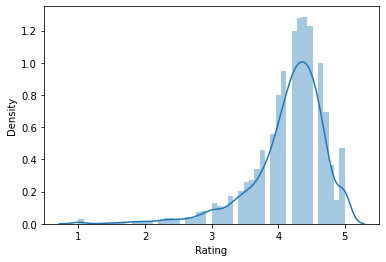

In [191]:
sns.distplot(df['Rating'])
print(np.mean(df['Rating']))

From the visualization, we can see that the data is skewed to the right, with there being significantly more values in the 4-5 range and the average being 4.16

### One Hot Encoding

We want to one hot encode the following variables

* **Category:** ART_AND_DESIGN, AUTO_AND_VEHICLES, BEAUTY, etc.
* **Installs:** 10,000+, 500,000+, 5,000,000+
* **Type:** Free, Paid
* **Content_Rating:** Everyone, Teen, Unrated, etc.
* **Genres:** Art_&_Design, Pretend_Play, Creativity, etc.
* **Last_Updated:** 2018, 2017, 2014, etc.

In [184]:
X.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7027 entries, 0 to 10840
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        7027 non-null   object 
 1   Reviews         7027 non-null   float64
 2   Size            7027 non-null   float64
 3   Installs        7027 non-null   float64
 4   Type            7027 non-null   object 
 5   Price           7027 non-null   float64
 6   Content_Rating  7027 non-null   object 
 7   Genres          7027 non-null   object 
 8   Last_Updated    7027 non-null   object 
dtypes: float64(4), object(5)
memory usage: 549.0+ KB


In [ ]:
#One hot Encoding
X_encoded = pd.get_dummies(X, columns = ['Category',
                                         'Installs',
                                         'Type',
                                         'Content_Rating',
                                         'Genres',
                                         'Last_Updated'])
X_encoded.head()

,Reviews,Size,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,...,Genres_Word,Last_Updated_2010,Last_Updated_2011,Last_Updated_2012,Last_Updated_2013,Last_Updated_2014,Last_Updated_2015,Last_Updated_2016,Last_Updated_2017,Last_Updated_2018
0,159.0,19000000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,967.0,14000000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,87510.0,8700000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,215644.0,25000000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,967.0,2800000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
y.dropna(inplace = True)
y
y.unique()

array([4.1, 3.9, 4.7, 4.5, 4.3, 4.4, 3.8, 4.2, 4.6, 3.2, 4. , 4.8, 4.9,
       3.6, 3.7, 3.3, 3.4, 3.5, 3.1, 5. , 2.6, 3. , 1.9, 2.5, 2.8, 2.7,
       1. , 2.9, 2.3, 2.2, 1.7, 2. , 1.8, 2.4, 1.6, 2.1, 1.4, 1.5, 1.2])

## Preliminary XGBoost Model

We  know that the Average Rating is a 4.16 in the dataset. We can split accordingly.

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.25, random_state = 10)

Now, lets verify that the average in our training and testing data is close to that of the entire dataset to ensure an even split in training and testing data.

In [221]:
sum(y_train)/len(y_train)

4.158102466793159

In [222]:
sum(y_test)/len(y_test)

4.168184405236192

In [227]:
xgb_r = xgb.XGBRegressor(objective = 'reg:linear', n_estimators = 10, seed = 42, silent = True)
xgb_r.fit(X_train, y_train)
pred = xgb_r.predict(X_test)

In [230]:
#Scoring by root mean square error (rmse)
rmse = np.sqrt(MSE(y_test, pred))
print('RMSE: % f' %(rmse))

RMSE:  0.515569


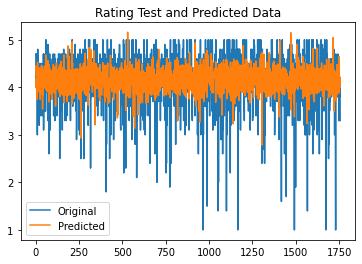

In [243]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label = 'Original')
plt.plot(x_ax, pred, label = 'Predicted')
plt.title("Rating Test and Predicted Data")
plt.legend()
plt.show()

Our model appears to be predicted values very close to the mean, having a hard time dealing with outliers.

## Optimizing Parameters

In [247]:
param_grid = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]
              }

In [248]:
xgb_grid = GridSearchCV(xgb_r,
                        param_grid,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [250]:
#takes some time to run
xgb_grid.fit(X_train,
         y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(n_estimators=500, seed=42, silent=True),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4],
                         'n_estimators': [500], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7]},
             verbose=True)

In [251]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.07550074748349361
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


Update params based on values they are leaning towards for a secondary gridsearch

In [ ]:
param_grid = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.01,.02,.03], 
              'max_depth': [3,4,5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]
              }

In [ ]:
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'multi:softprob',
                                  seed = 42,
                                  subsample = 0.9,
                                  colsample_bytree = 0.5),
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose = 0,
    n_jobs = 10,
    cv = 3
    )

In [ ]:
#TODO Random Forest Regressor

In [ ]:
#from scipy.stats import boxcox
#bcx_target, lam =boxcox(df['Rating'])
#xgb_model = xgb.XGBRegressor(random_state = 42)
#xgb_model.fit(X_train, y_train)

In [ ]:
#y_xgpred = xgb_model.predict(X_test)
#mse = mean_squared_error(inv_boxcox(y_test,lam), inv_boxcox(y_xgpred,lam))
#print('Mean Squared Error:',mse)

## OLS

In [ ]:
#from sklearn.linear_model import LinearRegression

#y = df.loc[:, 'Rating']
#X = df.loc[:, ~df.columns.isin(['Reviews', 'Installs', 'Size'])]

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Proposed Solution

The solution we will be implementing to reach our goal is using Ordinary Least Squares and linear regression, then using XGBoost and cross validation. In order to implement this we will have to follow distinct steps, including creating a weight vector, in which we would have to calculate the optimum w that yields the minimum loss and taking the gradient. Something that will help us analyze the code is one-hot encoding, where we will have to transform categorical data to numerical to allow further analysis. After completing this, with other types of wrangling, we will implement linear regression creating a function that follows the mathematical computation. Some function calls that we will be implementing are numpy, pandas, seaborn, sklearn to compare different features that affect app ratings to ultimately see what variable has the highest correlation. Other than OLS and linear regression, we will implement gradient boosted decision trees using XGBoost and compare models using cross validation.

# Evaluation Metrics

Since we are planning on using a regression model to predict app ratings from different features, one of the evaluation metrics we'll probably be using is the mean square error to determine the goodness of fit. Mean square error is calculated by the sum of the square of prediction error (expected output minus predicted output) divided by the number of data points, suggesting how far off our rating predictions are from the actual expected results. Another potential metric is using the mean absolute error, which is the same as mean square error except it takes the absolute value of prediction error instead of the square, to determine how far off our predictions are if we treat all errors the same. Mean square error will penalize big rating prediction errors more due to the square, but both metrics may be potential ways we could use to identify how good of a fit our model is.




# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for? 
### Ethics & Privacy

It is important for us to gather accurate data by checking its accuracy and reliability. It is also important for us to make sure that the data can be acquired by the public and is permitted by the owner. We need to be neutral about the evaluations and rely on evidence instead of assumptions. As for people's reviews on the apps, we should keep them anonymous in order to protect their privacies. A tool that can help us address these potential issues is https://deon.drivendata.org.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="1">1</a>: Houd, Anass El (19 Sept 2020) DS Project: How to Predict Google Apps Rating? *Towards Data Science*. https://towardsdatascience.com/ds-project-how-to-predict-google-apps-rating-618ebc77cad<br> 
<a name="2">2</a>: Lutkevich, Ben (Mar 2021) What is Natural Language Processing? An Introduction to NLP *Tech Target*. https://www.techtarget.com/searchenterpriseai/definition/natural-language-processing-NLP#:~:text=Natural%20language%20processing%20(NLP)%20is,in%20the%20field%20of%20linguistics<br>
<a name="3">3</a>: Pandey, Pranjal (7 Sept 2021) Machine Learning: Linear Regression and its applications *The Data Science Portal*. https://thedatascienceportal.com/posts/linear-regression-and-its-applications